# Inference Demo for ImageNet Models

## Overview
This notebook can be used for inference on ONNX models trained on **ImageNet** dataset. The demo shows how to use the trained models to do inference in MXNet. Please install the prerequisite packages if not already installed. 

## Model Support in This Demo

* SqueezeNet
* VGG
* ResNet
* MobileNet

## Prerequisites

* Protobuf compiler - `sudo apt-get install protobuf-compiler libprotoc-dev` (required for ONNX)
* ONNX - `pip install onnx`
* MXNet - `pip install mxnet-cu90mkl --pre -U` (tested on this version GPU, can use other versions. `--pre` indicates a pre build of MXNet which is required here for ONNX version compatibility. `-U` uninstalls any existing MXNet version allowing for a clean install)
* numpy - `pip install numpy`
* matplotlib - `pip install matplotlib`

In order to do inference with a python script: 
* Generate the script : In Jupyter Notebook browser, go to File -> Download as -> Python (.py)
* Run the script: `python imagenet_inference.py`

### Import dependencies
Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [ ]:
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from mxnet.gluon.data.vision import transforms
from mxnet.contrib.onnx._import.import_model import import_model
import os

### Test Images
A test image will be downloaded to test out inference. Feel free to provide your own image instead.

In [2]:
os.system('curl -O https://s3.amazonaws.com/model-server/inputs/kitten.jpg')

0

### Download synset file for ImageNet
Download and load synset.txt file containing class labels for ImageNet

In [3]:
os.system('curl -O https://s3.amazonaws.com/onnx-model-zoo/synset.txt')
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

### Import ONNX model
Import a model from ONNX to MXNet symbols and params

In [4]:
# Enter path to the ONNX model file
model_path= 'squeezenet1.1.onnx'
sym, arg_params, aux_params = import_model(model_path)

### Read image
`get_image(path, show=False)` : Read and show the image taking the `path` as input

In [5]:
Batch = namedtuple('Batch', ['data'])
def get_image(path, show=False):
    img = mx.image.imread(path)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    return img

### Preprocess image
`preprocess(img)` : Preprocess inference image -> resize to 256x256, take center crop of 224x224, normalize image, add a dimension to batchify the image

In [6]:
def preprocess(img):   
    transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform_fn(img)
    img = img.expand_dims(axis=0)
    return img

### Predict
`predict(path)` : Takes `path` of the input image and flag to display input image and prints 5 top predictions

In [7]:
def predict(path):
    img = get_image(path, show=True)
    img = preprocess(img)
    mod.forward(Batch([img]))
    # Take softmax to generate probabilities
    scores = mx.ndarray.softmax(mod.get_outputs()[0]).asnumpy()
    # print the top-5 inferences class
    scores = np.squeeze(scores)
    a = np.argsort(scores)[::-1]
    for i in a[0:5]:
        print('class=%s ; probability=%f' %(labels[i],scores[i]))

### Load the network for inference

In [8]:
# Determine and set context
if max(mx.test_utils.list_gpus())>=0:
    ctx = mx.gpu(0)
else:
    ctx = mx.cpu()
# Load module
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True, allow_extra=True)

### Generate predictions
The top 5 classes (in order) along with the probabilities generated for the image is displayed in the output of the cell below

class=n02124075 Egyptian cat ; probability=0.349889
class=n02123159 tiger cat ; probability=0.214085
class=n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor ; probability=0.184941
class=n02123045 tabby, tabby cat ; probability=0.157686
class=n02127052 lynx, catamount ; probability=0.088739


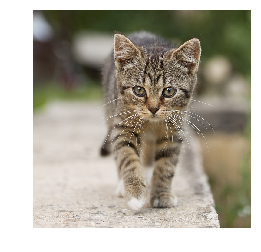

In [9]:
# Enter path to the inference image below
img_path = 'kitten.jpg'
predict(img_path)